# Mean-variance optimization

In this cookbook recipe, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities. I will discuss what I think should be your "default" options, based on my experience in optimising portfolios.

To start, you need a list of tickers. Some people just provide the whole universe of stocks, but I don't think this is a good idea - portfolio optimization is quite different from asset selection. I would suggest anywhere from 10-50 stocks as a starting point.

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Optimising along the mean-semivariance frontier
- Optimising along the mean-CVaR frontier
- Plotting the efficient frontier:
    - Simple (using CLA)
    - Constrained
    - Complex plots

Please consult the [docs](https://pyportfolioopt.readthedocs.io/) for more info.

## Downloading data

To download data, we will use `yfinance`, an excellent library that provides free price data from Yahoo Finance, no API key needed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/PyPortfolio/PyPortfolioOpt/blob/main/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/pyportfolio/pyportfolioopt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/pyportfolio/pyportfolioopt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb)

In [7]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/pyportfolio/pyportfolioopt.git')
    os.chdir('PyPortfolioOpt/cookbook')


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
tickers = ["MSFT", "AMZN", "KO", "MA", "COST", 
           "LUV", "XOM", "PFE", "JPM", "UNH", 
           "ACN", "DIS", "GILD", "F", "TSLA"] 

In [10]:
ohlc = yf.download(tickers, period="max").loc["1990":]

/var/folders/_3/k_9k5d5n5zz57w7qfll9rzs40000gn/T/ipykernel_59786/3860718606.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ohlc = yf.download(tickers, period="max").loc["1990":]
[*********************100%***********************]  15 of 15 completed


In [11]:
prices = ohlc["Close"].dropna(how="all")
prices.tail()

Ticker             ACN        AMZN        COST         DIS          F  \
Date                                                                    
2025-11-05  247.820007  250.199997  935.030029  111.360001  12.960114   
2025-11-06  241.339996  243.039993  923.580017  110.489998  12.969999   
2025-11-07  245.759995  244.410004  922.739990  110.739998  13.210000   
2025-11-10  244.550003  248.399994  915.559998  112.239998  13.160000   
2025-11-11  242.559998  249.100006  913.859985  114.849998  13.300000   

Ticker            GILD         JPM         KO        LUV          MA  \
Date                                                                   
2025-11-05  122.580002  311.679993  68.510002  31.620001  553.309998   
2025-11-06  123.400002  313.420013  69.059998  31.510000  553.280029   
2025-11-07  118.839996  314.209991  70.550003  32.450001  551.969971   
2025-11-10  118.150002  316.890015  70.519997  32.660000  552.960022   
2025-11-11  122.559998  315.619995  71.610001  31.990000  558.349976   

Ticker            MSFT        PFE        TSLA         UNH         XOM  
Date                                                                   
2025-11-05  507.160004  24.184153  462.070007  327.739990  113.680000  
2025-11-06  497.100006  24.420000  445.910004  321.559998  114.500000  
2025-11-07  496.820007  24.430000  429.519989  324.209991  117.220001  
2025-11-10  506.000000  24.389999  445.230011  321.579987  118.220001  
2025-11-11  508.679993  25.510000  439.619995  327.450012  119.779999

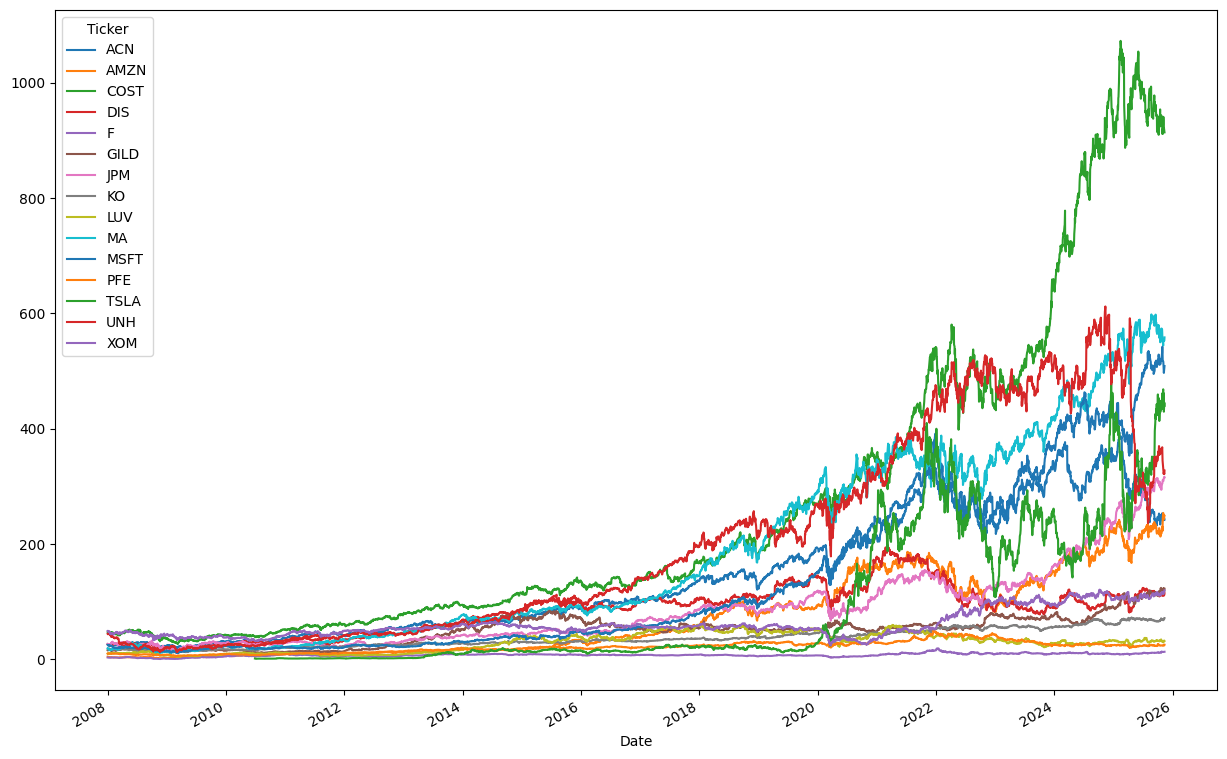

In [12]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

## Calculating the covariance matrix

In [13]:
import pypfopt
pypfopt.__version__

'1.5.6'

In [14]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

Ticker       ACN      AMZN      COST       DIS         F      GILD       JPM  \
Ticker                                                                         
ACN     0.087879  0.045211  0.027071  0.039502  0.042549  0.027293  0.044863   
AMZN    0.045211  0.307429  0.045653  0.054003  0.051213  0.052769  0.061962   
COST    0.027071  0.045653  0.092634  0.027938  0.029847  0.025282  0.035684   
DIS     0.039502  0.054003  0.027938  0.089013  0.042917  0.030226  0.049604   
F       0.042549  0.051213  0.029847  0.042917  0.150588  0.028601  0.059010   
GILD    0.027293  0.052769  0.025282  0.030226  0.028601  0.217525  0.039475   
JPM     0.044863  0.061962  0.035684  0.049604  0.059010  0.039475  0.133386   
KO      0.019031  0.018045  0.017898  0.021648  0.022414  0.016203  0.024977   
LUV     0.036189  0.046514  0.028906  0.041307  0.050190  0.029633  0.052660   
MA      0.043097  0.052424  0.030250  0.046985  0.056848  0.029258  0.062078   
MSFT    0.039949  0.070593  0.033754  0.037004  0.038372  0.032517  0.045667   
PFE     0.024414  0.028826  0.022277  0.024385  0.024299  0.031389  0.031981   
TSLA    0.042784  0.068915  0.030881  0.044845  0.059557  0.028156  0.042675   
UNH     0.028149  0.031414  0.023572  0.028374  0.028534  0.032010  0.037662   
XOM     0.027694  0.024803  0.017215  0.027860  0.030204  0.019950  0.034202   

Ticker        KO       LUV        MA      MSFT       PFE      TSLA       UNH  \
Ticker                                                                         
ACN     0.019031  0.036189  0.043097  0.039949  0.024414  0.042784  0.028149   
AMZN    0.018045  0.046514  0.052424  0.070593  0.028826  0.068915  0.031414   
COST    0.017898  0.028906  0.030250  0.033754  0.022277  0.030881  0.023572   
DIS     0.021648  0.041307  0.046985  0.037004  0.024385  0.044845  0.028374   
F       0.022414  0.050190  0.056848  0.038372  0.024299  0.059557  0.028534   
GILD    0.016203  0.029633  0.029258  0.032517  0.031389  0.028156  0.032010   
JPM     0.024977  0.052660  0.062078  0.045667  0.031981  0.042675  0.037662   
KO      0.047342  0.019165  0.023770  0.020717  0.021349  0.014569  0.021770   
LUV     0.019165  0.137159  0.045174  0.033364  0.024131  0.047666  0.030239   
MA      0.023770  0.045174  0.105872  0.045315  0.028930  0.046905  0.037390   
MSFT    0.020717  0.033364  0.045315  0.098125  0.025940  0.052774  0.029705   
PFE     0.021349  0.024131  0.028930  0.025940  0.070425  0.017049  0.027943   
TSLA    0.014569  0.047666  0.046905  0.052774  0.017049  0.335304  0.026924   
UNH     0.021770  0.030239  0.037390  0.029705  0.027943  0.026924  0.130707   
XOM     0.019547  0.022862  0.037327  0.023631  0.021544  0.026332  0.022519   

Ticker       XOM  
Ticker            
ACN     0.027694  
AMZN    0.024803  
COST    0.017215  
DIS     0.027860  
F       0.030204  
GILD    0.019950  
JPM     0.034202  
KO      0.019547  
LUV     0.022862  
MA      0.037327  
MSFT    0.023631  
PFE     0.021544  
TSLA    0.026332  
UNH     0.022519  
XOM     0.061641

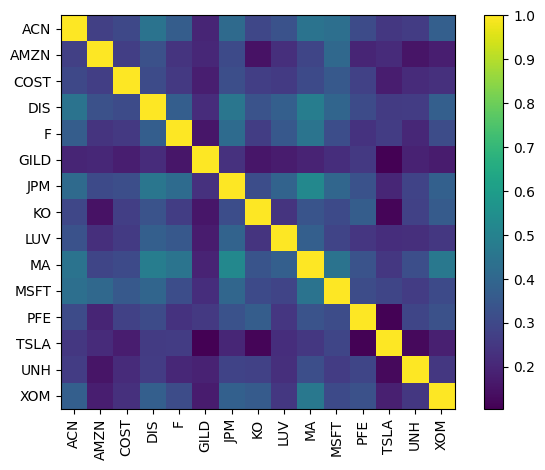

In [15]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

For reasons discussed in the docs, the sample covariance matrix should not be your default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

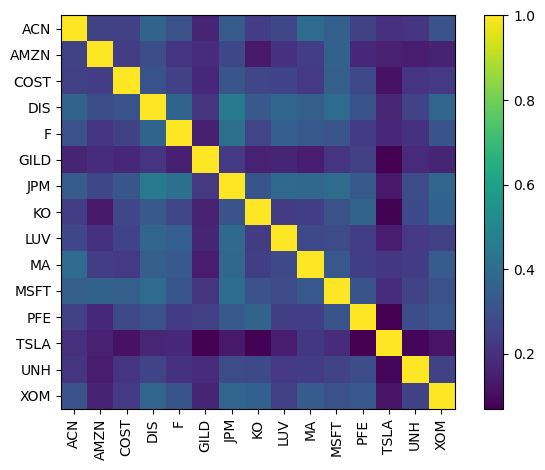

In [16]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation

As discussed in the docs, it is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that you may be better off not providing expected returns – you can then just find the `min_volatility()` portfolio or use `HRP`. 

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. Please see the notebook `1-RiskReturnModels.ipynb` for more information.

In [17]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

Ticker
ACN     0.202011
AMZN    0.352581
COST    0.175672
DIS     0.206533
F       0.241105
GILD    0.240912
JPM     0.263090
KO      0.118175
LUV     0.224131
MA      0.244448
MSFT    0.215577
PFE     0.152560
TSLA    0.309169
UNH     0.193748
XOM     0.139997
Name: mkt, dtype: float64

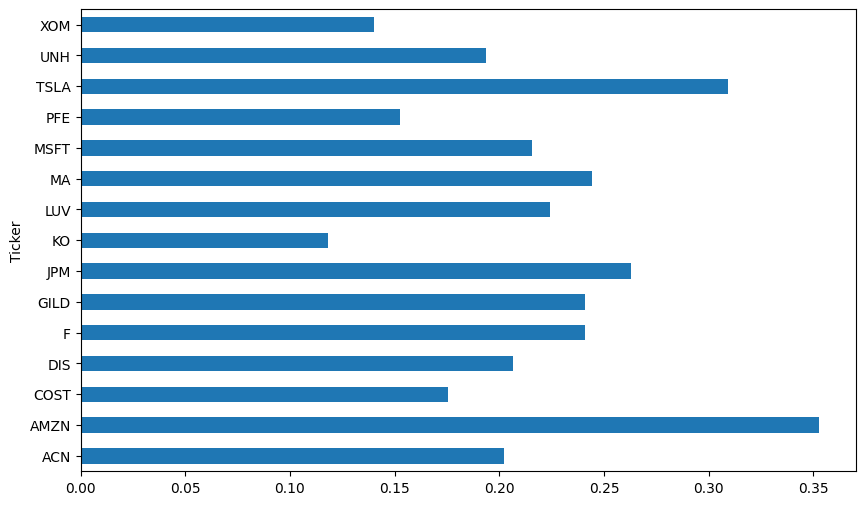

In [18]:
mu.plot.barh(figsize=(10,6));

## Long/short min variance

In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios.

In [19]:
from pypfopt import EfficientFrontier

In [20]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.15633),
             ('AMZN', 0.00186),
             ('COST', 0.0855),
             ('DIS', 0.00281),
             ('F', -0.01711),
             ('GILD', 0.03164),
             ('JPM', -0.06418),
             ('KO', 0.2675),
             ('LUV', 0.02184),
             ('MA', 0.17125),
             ('MSFT', -0.00282),
             ('PFE', 0.10258),
             ('TSLA', 0.08633),
             ('UNH', 0.02722),
             ('XOM', 0.12927)])

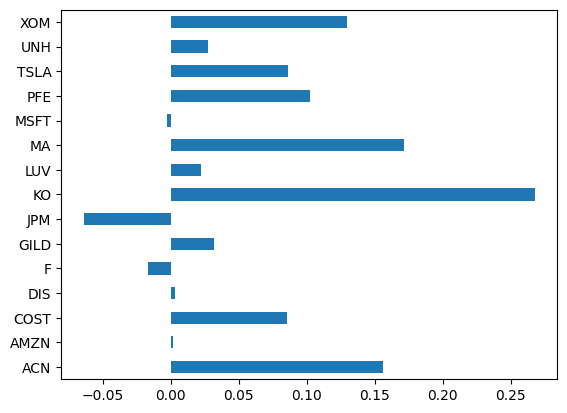

In [21]:
pd.Series(weights).plot.barh();

We can get a quick indication of the portfolio performance as follows. Note that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs!

In [22]:
ef.portfolio_performance(verbose=True);

Annual volatility: 15.2%


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares.  To do this, we would need to construct a **discrete allocation** (unless your broker supports fractional shares!)

If we had \$20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [23]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $61.86 leftover


/Users/thomasschmelzer/projects/PyPortfolioOpt/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'ACN': 12,
 'COST': 2,
 'DIS': 1,
 'GILD': 4,
 'KO': 69,
 'LUV': 13,
 'MA': 6,
 'PFE': 74,
 'TSLA': 3,
 'UNH': 1,
 'XOM': 20,
 'F': -92,
 'JPM': -15}

## Max Sharpe with sector constraints

If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A `sector_mapper`, your `sector_lower` bounds, and your `sector_upper` bounds.

In [24]:
sector_mapper = {
    "MSFT": "Tech",
    "AMZN": "Consumer Discretionary",
    "KO": "Consumer Staples",
    "MA": "Financial Services",
    "COST": "Consumer Staples",
    "LUV": "Aerospace",
    "XOM": "Energy",
    "PFE": "Healthcare",
    "JPM": "Financial Services",
    "UNH": "Healthcare",
    "ACN": "Misc",
    "DIS": "Media",
    "GILD": "Healthcare",
    "F": "Auto",
    "TSLA": "Auto"
}

sector_lower = {
    "Consumer Staples": 0.1, # at least 10% to staples
    "Tech": 0.05 # at least 5% to tech
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Tech": 0.2,
    "Aerospace":0.1,
    "Energy": 0.1,
    "Auto":0.15
}

We then set up the optimizer and add our constraints. We can use `ef.add_objective()` to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

- 10% of the portfolio in AMZN
- Less than 5% of my portfolio in TSLA

In [25]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AMZN")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.05)

ef.add_constraint(lambda w: w[10] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [26]:
weights

OrderedDict([('ACN', 0.15093),
             ('AMZN', 0.1),
             ('COST', 0.04217),
             ('DIS', 0.0),
             ('F', 0.01733),
             ('GILD', 0.06261),
             ('JPM', 0.01013),
             ('KO', 0.05783),
             ('LUV', 0.03754),
             ('MA', 0.34004),
             ('MSFT', 0.05),
             ('PFE', 0.03928),
             ('TSLA', 0.05),
             ('UNH', 0.04214),
             ('XOM', 0.0)])

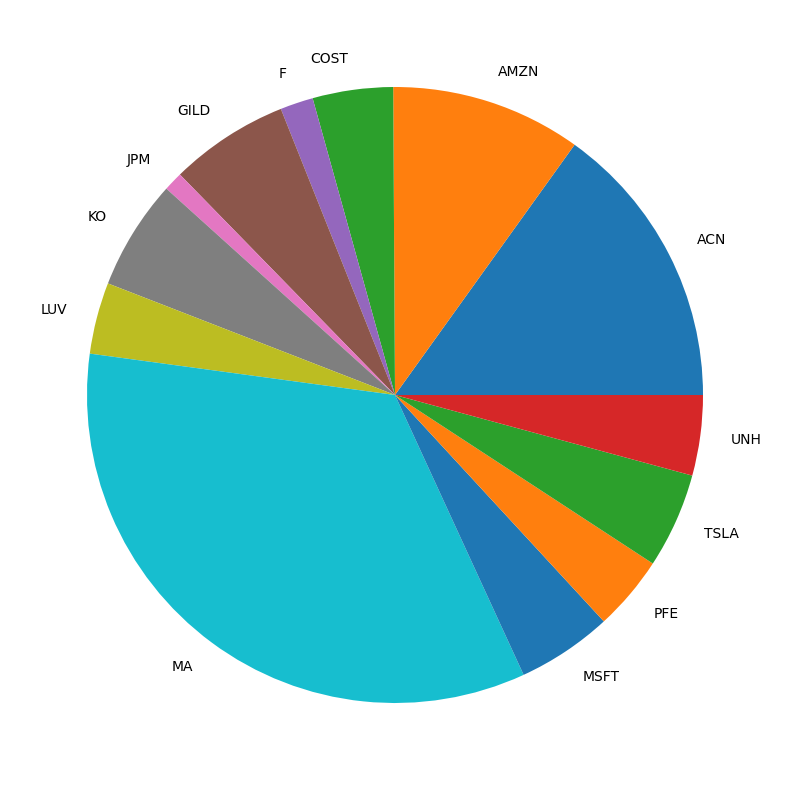

In [27]:
pd.Series(weights).plot.pie(figsize=(10,10));

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:


In [28]:
# O(N^2) loop not a good idea in a coding interview :)
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Consumer Discretionary: 0.100
Consumer Staples: 0.100
Healthcare: 0.144
Tech: 0.050
Energy: 0.000
Aerospace: 0.038
Misc: 0.151
Auto: 0.067
Media: 0.000
Financial Services: 0.350


## Maximise return for a given risk, with L2 regularisation

Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 15% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [29]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.20)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.02674),
             ('AMZN', 0.15123),
             ('COST', 0.1),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.06766),
             ('JPM', 0.06285),
             ('KO', 0.0),
             ('LUV', 0.01736),
             ('MA', 0.37416),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.0),
             ('XOM', 0.0)])

In [30]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

6/15 tickers have zero weight


In [31]:
ef.portfolio_performance(verbose=True);

Expected annual return: 26.2%
Annual volatility: 20.0%
Sharpe Ratio: 1.31


While this portfolio seems like it meets our objectives, we might be worried by the fact that a lot of the tickers have been assigned zero weight. In effect, the optimizer is "overfitting" to the data you have provided -- you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use **L2 regularisation** – essentially, adding a penalty on the number of near-zero weights.

In [32]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamma is the tuning parameter
ef.efficient_risk(0.2)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.06969),
             ('AMZN', 0.16698),
             ('COST', 0.08443),
             ('DIS', 0.00642),
             ('F', 0.0),
             ('GILD', 0.07658),
             ('JPM', 0.09307),
             ('KO', 0.01557),
             ('LUV', 0.04691),
             ('MA', 0.21322),
             ('MSFT', 0.05),
             ('PFE', 0.0),
             ('TSLA', 0.15),
             ('UNH', 0.02714),
             ('XOM', 0.0)])

In [33]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

3/15 tickers have zero weight


We can tune the value of gamma to choose the number of nonzero tickers. Larger gamma pulls portfolio weights towards an equal allocation.

In [34]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=1)  # gamma is the tuning parameter
ef.efficient_risk(0.2)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', 0.05848),
             ('AMZN', 0.13376),
             ('COST', 0.06437),
             ('DIS', 0.06074),
             ('F', 0.05798),
             ('GILD', 0.07793),
             ('JPM', 0.08902),
             ('KO', 0.03563),
             ('LUV', 0.06954),
             ('MA', 0.0797),
             ('MSFT', 0.06526),
             ('PFE', 0.03375),
             ('TSLA', 0.09202),
             ('UNH', 0.05435),
             ('XOM', 0.02747)])

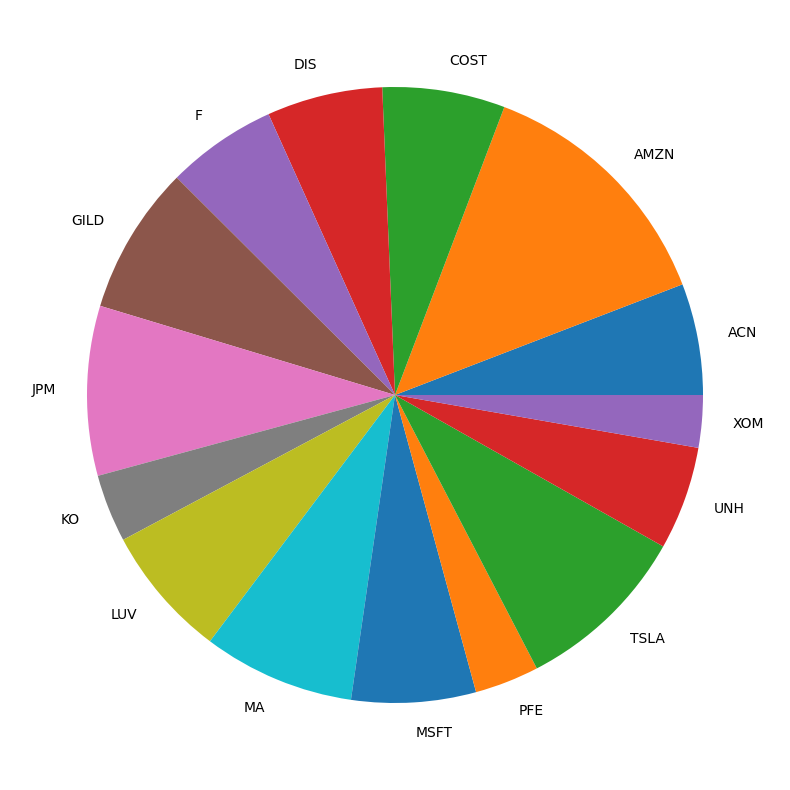

In [35]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [36]:
ef.portfolio_performance(verbose=True);

Expected annual return: 24.0%
Annual volatility: 19.5%
Sharpe Ratio: 1.23


The resulting portfolio still has a volatility of less than our 15% limit. It's in-sample Sharpe ratio has gone down, but this portfolio is a lot more robust for actual investment.

## Minimise risk for a given return, market-neutral

We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.  

In [37]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('ACN', -0.02187),
             ('AMZN', 0.16537),
             ('COST', -0.05722),
             ('DIS', -0.01548),
             ('F', 0.03129),
             ('GILD', 0.0305),
             ('JPM', 0.06344),
             ('KO', -0.13748),
             ('LUV', 0.00881),
             ('MA', 0.03921),
             ('MSFT', -0.00471),
             ('PFE', -0.08735),
             ('TSLA', 0.12025),
             ('UNH', -0.02798),
             ('XOM', -0.10678)])

In [38]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 11.1%
Sharpe Ratio: 0.63


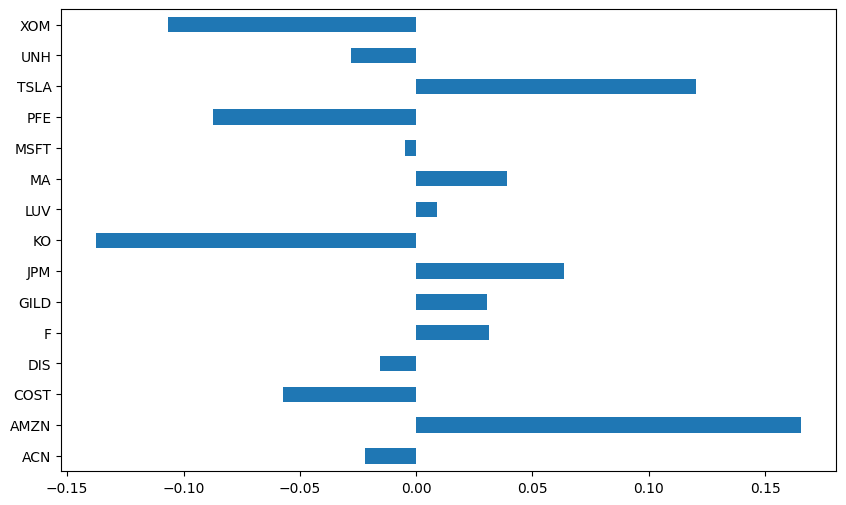

In [39]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [40]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: -0.00


## Efficient semi-variance optimization

In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into `EfficientFrontier` (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).

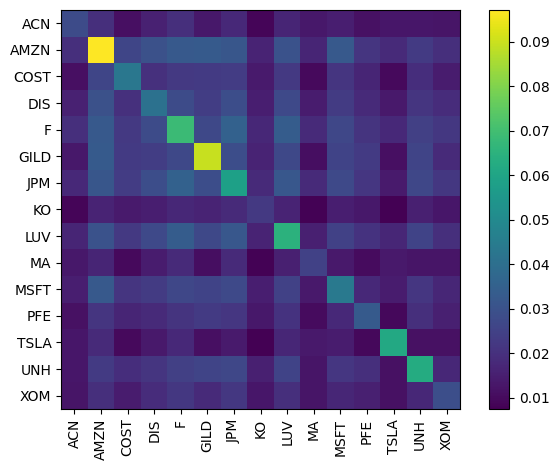

In [41]:
semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

In [42]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights


OrderedDict([('ACN', 0.16819),
             ('AMZN', 0.0),
             ('COST', 0.0607),
             ('DIS', 0.0),
             ('F', 0.0),
             ('GILD', 0.00822),
             ('JPM', 0.0),
             ('KO', 0.25592),
             ('LUV', 0.0),
             ('MA', 0.31923),
             ('MSFT', 0.0),
             ('PFE', 0.07272),
             ('TSLA', 0.10584),
             ('UNH', 0.0),
             ('XOM', 0.00918)])

In [43]:
ef.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual volatility: 11.9%
Sharpe Ratio: 1.68


However, this solution is not truly optimal in mean-semivariance space. To do the optimization properly, we must use the `EfficientSemivariance` class. This requires us to first compute the returns and drop NaNs.

In [44]:
returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

In [45]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);


Expected annual return: 20.0%
Annual semi-deviation: 10.6%
Sortino Ratio: 1.89


To compare this with the heuristic solution, I will use a quick hack: replacing the `es.weights` with `es.weights` and running `es.portfolio_performance` again. Please don't be encouraged to do this in real life!

In [46]:
es.weights = ef.weights
es.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual semi-deviation: 12.9%
Sortino Ratio: 1.55


We see that the heuristic method has a significantly lower Sortino ratio, and much higher semivariance.

## Efficient CVaR optimization

In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.

In [47]:
returns = expected_returns.returns_from_prices(prices).dropna()
returns.head()

Ticker           ACN      AMZN      COST       DIS         F      GILD  \
Date                                                                     
2010-06-30  0.000000  0.005985 -0.014380 -0.024767  0.020243 -0.019731   
2010-07-01 -0.009573  0.015559  0.001276 -0.000318  0.048611 -0.004084   
2010-07-02 -0.008882 -0.016402 -0.012204 -0.003493 -0.027436  0.021383   
2010-07-06  0.012388  0.008430 -0.004241  0.010835 -0.011673 -0.002868   
2010-07-07  0.022130  0.030620  0.005370  0.044767  0.042322  0.004889   

Ticker           JPM        KO       LUV        MA      MSFT       PFE  \
Date                                                                     
2010-06-30 -0.012143 -0.004173  0.000000 -0.017045 -0.012870 -0.001400   
2010-07-01 -0.013129 -0.001796 -0.010801  0.016651  0.006519 -0.002104   
2010-07-02 -0.006929  0.000400 -0.021838  0.000346  0.004749 -0.006325   
2010-07-06  0.013955  0.007593 -0.011163 -0.013513  0.023636  0.010608   
2010-07-07  0.050097  0.020622  0.062089  0.037694  0.020151  0.023093   

Ticker          TSLA       UNH       XOM  
Date                                      
2010-06-30 -0.002511 -0.008034 -0.003840  
2010-07-01 -0.078473 -0.019366 -0.008060  
2010-07-02 -0.125683  0.016158 -0.000707  
2010-07-06 -0.160937  0.020848  0.015733  
2010-07-07 -0.019243  0.010730  0.016882

In [48]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 24.2%
Annual volatility: 17.7%
Sharpe Ratio: 1.36


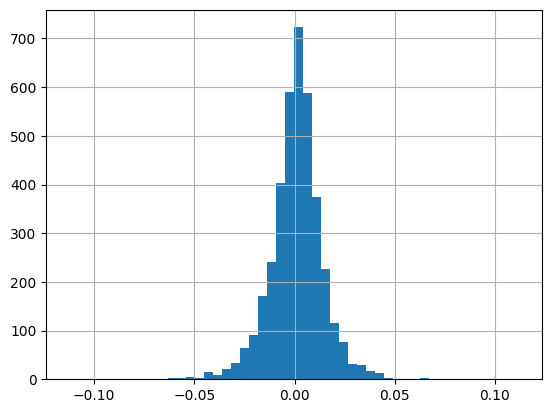

In [49]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

In [50]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.10%
CVaR: -3.12%


This value of the CVaR means that our average loss on the worst 5% of days will be -3.35%. Let's say that this were beyond our comfort zone (for a \\$100,000 portfolio, this would mean losing \\$3350 in a day).

Let's firstly construct the portfolio with the minimum CVaR:

In [51]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 15.1%
Conditional Value at Risk: 2.07%


We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use `efficient_risk` to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [52]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

Expected annual return: 23.4%
Conditional Value at Risk: 2.50%


We now have similar returns to before (24.7% vs 25.8%), but with a lower tail risk (2.50% CVaR vs 3.35%). 

## Plotting - Unconstrained

To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm. 

In [53]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 24.2%
Annual volatility: 17.7%
Sharpe Ratio: 1.36


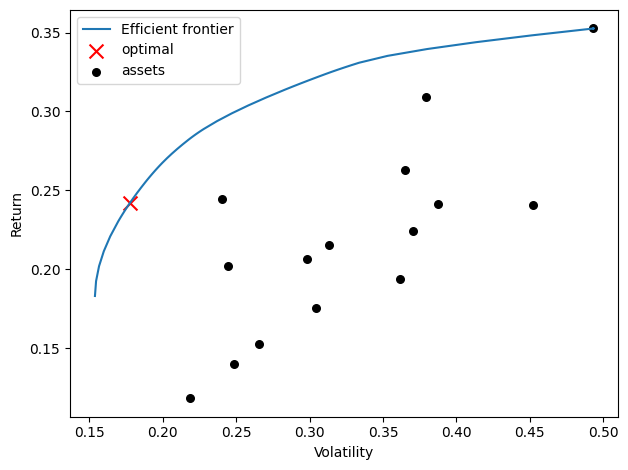

In [54]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

Interactive plots via Plotly are now supported too.

In [55]:
ax = plotting.plot_efficient_frontier(cla, showfig=False, interactive=True)
ax.show()

## Plotting - Constrained

In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to MSFT, AMZN, and TSLA (e.g maybe we want to avoid big tech).

In [56]:
import cvxpy as cp

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"MSFT", "AMZN", "TSLA"} for t in tickers]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

In [57]:
mu

Ticker
ACN     0.202011
AMZN    0.352581
COST    0.175672
DIS     0.206533
F       0.241105
GILD    0.240912
JPM     0.263090
KO      0.118175
LUV     0.224131
MA      0.244448
MSFT    0.215577
PFE     0.152560
TSLA    0.309169
UNH     0.193748
XOM     0.139997
Name: mkt, dtype: float64

As per the docs, *before* we call any optimization function, we should pass this to the plotting module:

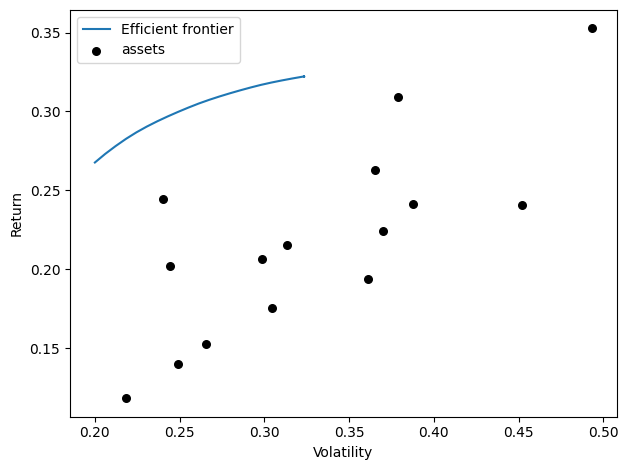

In [58]:
ax = plotting.plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.2, 0.5, 50), 
                                      showfig=False);

## Complex plots

The `plotting` module allows you to pass in an `ax`, on top of which the plots are added. This allows you to build complex plots. 

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios. 

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):

In [59]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.20296863 0.22650091 0.21093727 ... 0.24826296 0.22017591 0.19811965]
Sample portfolio volatilities: 0       0.176258
1       0.212849
2       0.186047
3       0.182062
4       0.202531
          ...   
9995    0.199046
9996    0.204033
9997    0.220805
9998    0.190212
9999    0.187209
Length: 10000, dtype: float64


Note that the above code is equivalent to generating samples via a for loop (just more efficient)

In [60]:
# mus = []
# stds = []
# sharpes = []
# for _ in range(10000):
#     w = np.random.dirichlet(np.ones(len(mu)))
#     # w = np.random.rand(len(mu))
#     # w /= w.sum()
#     ret = mu.dot(w)
#     std = np.sqrt(w.dot(S @ w))
#     mus.append(ret)
#     stds.append(std)
#     sharpes.append(ret / std)

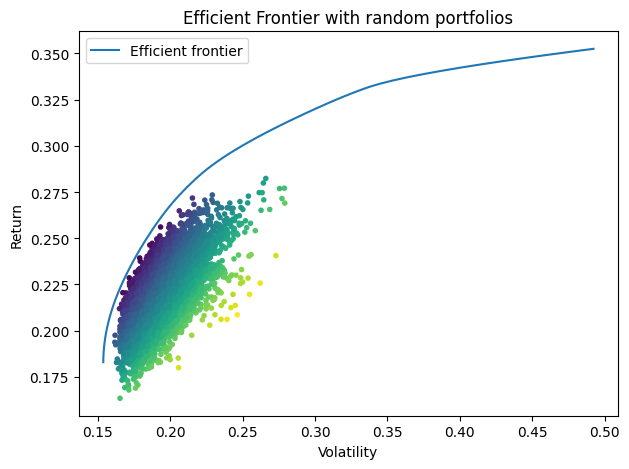

In [61]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
